In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math

import warnings
warnings.filterwarnings("ignore")

##Deep Learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import Bidirectional

Using TensorFlow backend.


In [3]:
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
    data = pd.read_csv(datapath)
    print('Rows, Columns: ', data.shape)
    display(data.sample(5))
    return data
    
    
train_df = load_data('timeseries_salesdata/train.csv')
test_df = load_data('timeseries_salesdata/test.csv')
sample_df = load_data('timeseries_salesdata/sample_submission.csv')

Rows, Columns:  (913000, 4)


,date,store,item,sales
502169,2013-01-20,6,28,51
544546,2014-02-03,9,30,29
834111,2016-12-26,7,46,32
221763,2015-03-29,2,13,106
88863,2016-04-30,9,5,22


Rows, Columns:  (45000, 4)


,id,date,store,item
26337,26337,2018-02-27,3,30
32276,32276,2018-02-26,9,36
36734,36734,2018-01-15,9,41
32254,32254,2018-02-04,9,36
8802,8802,2018-03-14,8,10


Rows, Columns:  (45000, 2)


,id,sales
21779,21779,52
17321,17321,52
35887,35887,52
4671,4671,52
14094,14094,52


In [4]:
def sales_dist(data):
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

total_points = pd.value_counts(sales_df.sales_bins).sum()
print('sales range & overall percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

sales range & overall percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

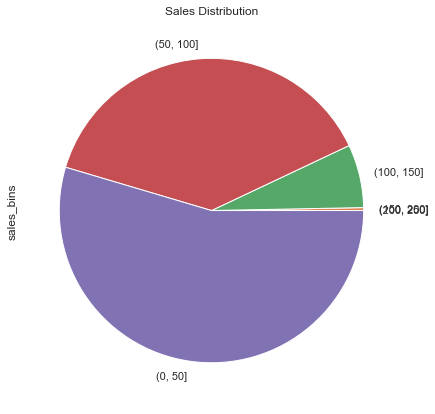

In [5]:
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='pie', title='Sales Distribution', figsize=(7, 7));

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item          7          8          9          10  ...         41         42   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  20.002738  33.105696   
2      75.058598  99.090361  65.478094  94.097481  ...  28.069551  47.368018   
3      66.647864  87.517525  58.486857  83.387733  ...  24.989047  41.797371   
4      61.625411  80.819825  54.043812  77.047645  ...  23.168127  38.539978   
5      44.535597  58.565717  38.837349  55.509858  ...  16.830778  27.730559   
6      44.599124  58.385542  39.460022  55.565170  ...  16.607338  27.893209   
7      40.709748  53.723987  35.901972  51.156627  ...  15.471522  25.435926   
8      71.730559  94.461117  63.193319  89.818182  ...  27.036145  45.144031   
9      61.812158  81.287514  54.105696  77.105148  ...  23.191128  38.643483   
10     65.807777  86.176889  57.886637  82.232202  ...  24.654984  41.222892   

                                                                          \
item          43         44          45         46         47         48   
store                                                                      
1      46.242607  26.594195   72.720701  52.845016  19.814348  46.546002   
2      65.785323  37.785871  103.381161  75.219606  28.187842  66.028478   
3      58.197700  33.386090   91.851041  66.748083  25.120482  58.700986   
4      54.018620  30.952355   84.687295  61.420044  23.114458  53.765608   
5      39.163198  22.415115   61.427163  44.734940  16.699343  39.281490   
6      39.034502  22.322563   61.142935  44.539978  16.708653  39.052574   
7      35.426068  20.446331   55.905805  40.828587  15.479189  35.624315   
8      62.980285  36.194414   98.941402  72.004929  27.150055  62.737130   
9      54.152793  30.968237   85.093647  62.010953  23.003286  53.976999   
10     57.942497  32.916758   90.690581  66.046550  24.755750  57.814896   

                             
item          49         50  
store                        
1      26.461665  59.342826  
2      37.711939  84.622125  
3      33.259584  74.958379  
4      30.840635  68.921687  
5      22.371851  50.319277  
6      22.181271  50.516429  
7      20.406353  45.823658  
8      36.035049  80.972070  
9      31.052574  69.308324  
10     33.032311  74.037240  

[10 rows x 50 columns]

<Figure size 1440x720 with 0 Axes>

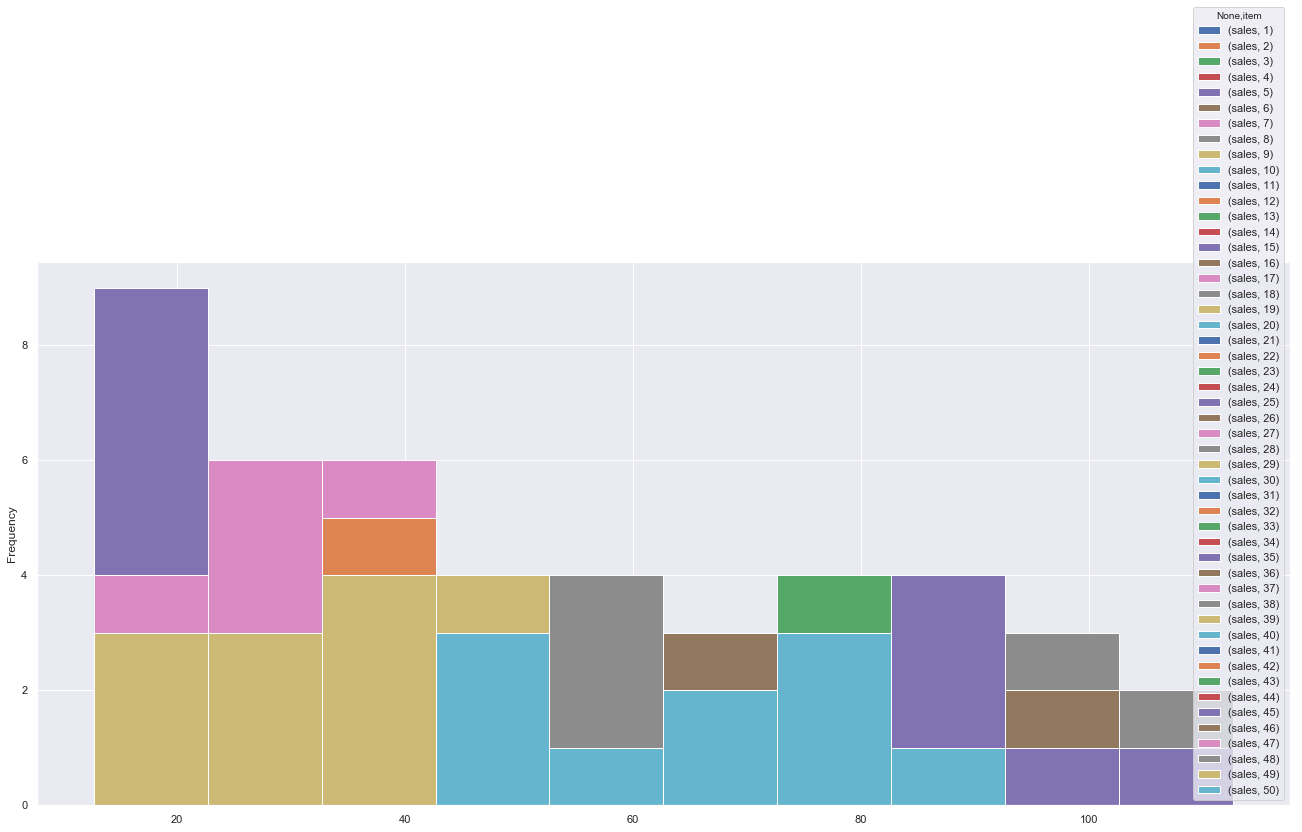

In [6]:
#shows sales across stores for each item
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

In [7]:
# average sales calculation
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [42]:
# average sales catter plot
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Average Sales/Store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 9,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Average Sales',
        ticklen= 9,
        zeroline= False,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig ,filename='scatter_sales_store')

In [8]:
def sales_insight(sales_pivoted_df):
    sales_across_item_df = sales_pivoted_df.copy()
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [10]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# the scatter plot
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of average sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Average Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

In [12]:
def Time_visualization(data):
    store_item_df = data.copy()
    store_id = 10   
    item_id = 40    

    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]

    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

In [13]:
def sales_monthly(data):
    multi_store_item_df = data.copy()

    store_ids = [1, 1, 1, 1]   
    item_ids = [10, 20, 30, 40]    
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (7304, 4)


In [14]:
train_df = pd.read_csv('timeseries_salesdata/train.csv', index_col='date', parse_dates=['date'])
test_df = pd.read_csv('timeseries_salesdata/test.csv', index_col='date', parse_dates=['date'])


In [15]:
train_df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [16]:
item1 = train_df[train_df['item']==1]
item1store1 = item1[item1['store']==1]
item1store1.head(2000)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [18]:
training_set = item1store1[:'2016'].iloc[:,2:3].values
test_set = item1store1['2017':].iloc[:,2:3].values
print(training_set)

[[13]
 [11]
 [14]
 ...
 [21]
 [24]
 [14]]


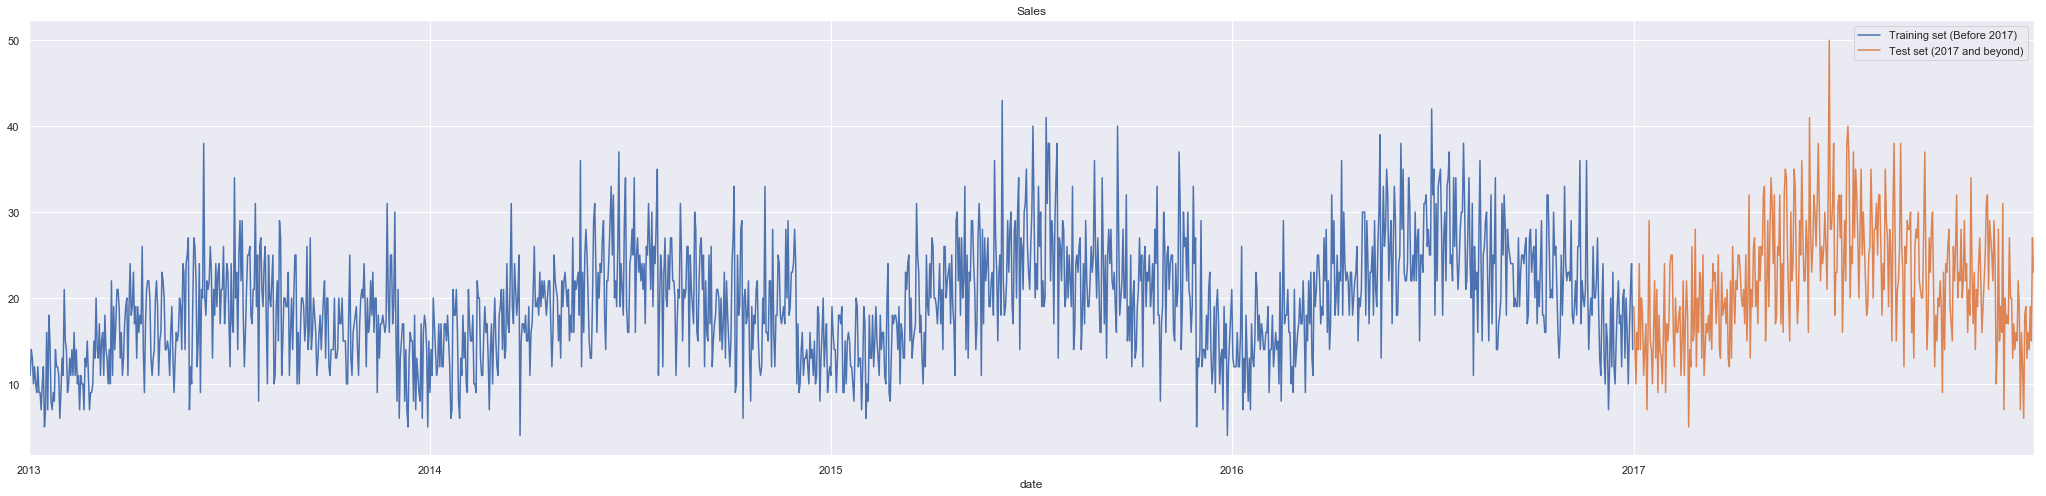

In [19]:
item1store1["sales"][:'2016'].plot(figsize=(32, 8),legend=True)
item1store1["sales"]['2017':].plot(figsize=(32, 8),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Sales')
plt.show()

In [20]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled)

[[0.23076923]
 [0.17948718]
 [0.25641026]
 ...
 [0.43589744]
 [0.51282051]
 [0.25641026]]


In [22]:
X_train = []
y_train = []
for i in range(60,1460):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [23]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [24]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0321
Epoch 2/50
1400/1400 [==============================] - 13s 9ms/step - loss: 0.0246
Epoch 3/50
1400/1400 [==============================] - 12s 8ms/step - loss: 0.0249
Epoch 4/50
1400/1400 [==============================] - 12s 8ms/step - loss: 0.0235
Epoch 5/50
1400/1400 [==============================] - 12s 9ms/step - loss: 0.0229
Epoch 6/50
1400/1400 [==============================] - 12s 9ms/step - loss: 0.0223
Epoch 7/50
1400/1400 [==============================] - 13s 9ms/step - loss: 0.0221
Epoch 8/50
1400/1400 [==============================] - 11s 8ms/step - loss: 0.0213
Epoch 9/50
1400/1400 [==============================] - 12s 9ms/step - loss: 0.0213
Epoch 10/50
1400/1400 [==============================] - 12s 8ms/step - loss: 0.0217
Epoch 11/50
1400/1400 [==============================] - 13s 9ms/step - loss: 0.0214
Epoch 12/50
1400/1400 [==============================] - 11s 8ms/step - l

In [25]:
dataset_total = pd.concat((item1store1["sales"][:'2016'],item1store1["sales"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [26]:
X_test = []
for i in range(60,425):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_sales = regressor.predict(X_test)
predicted_sales = sc.inverse_transform(predicted_sales)

In [27]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Sales')
    plt.plot(predicted, color='blue',label='Predicted Sales')
    plt.title('Demand Forecast: Item 1 in Store 1')
    plt.xlabel('Day in 2017')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [28]:
v_test_set = np.resize(test_set, (251, 1))
#v_test_set = np.reshape(v_test_set, (1, 251))
print(v_test_set)

[[19]
 [15]
 [10]
 [16]
 [14]
 [24]
 [14]
 [20]
 [18]
 [11]
 [14]
 [17]
 [ 7]
 [16]
 [29]
 [15]
 [14]
 [10]
 [16]
 [22]
 [13]
 [21]
 [ 9]
 [18]
 [14]
 [13]
 [10]
 [16]
 [24]
 [ 9]
 [17]
 [15]
 [17]
 [24]
 [25]
 [25]
 [16]
 [12]
 [20]
 [16]
 [16]
 [18]
 [19]
 [11]
 [15]
 [22]
 [11]
 [17]
 [22]
 [18]
 [ 5]
 [14]
 [12]
 [26]
 [15]
 [16]
 [28]
 [12]
 [20]
 [16]
 [23]
 [22]
 [13]
 [25]
 [11]
 [14]
 [17]
 [16]
 [18]
 [15]
 [21]
 [14]
 [24]
 [22]
 [23]
 [17]
 [20]
 [25]
 [14]
 [13]
 [23]
 [18]
 [19]
 [20]
 [17]
 [21]
 [13]
 [12]
 [22]
 [13]
 [26]
 [21]
 [17]
 [22]
 [21]
 [25]
 [25]
 [23]
 [20]
 [19]
 [21]
 [17]
 [25]
 [15]
 [20]
 [32]
 [13]
 [21]
 [19]
 [26]
 [27]
 [19]
 [22]
 [17]
 [26]
 [22]
 [26]
 [25]
 [32]
 [33]
 [15]
 [21]
 [29]
 [19]
 [28]
 [34]
 [31]
 [24]
 [32]
 [17]
 [18]
 [26]
 [25]
 [32]
 [17]
 [24]
 [16]
 [32]
 [35]
 [34]
 [25]
 [20]
 [15]
 [30]
 [22]
 [24]
 [35]
 [33]
 [23]
 [17]
 [20]
 [29]
 [25]
 [36]
 [27]
 [22]
 [22]
 [29]
 [26]
 [16]
 [41]
 [28]
 [23]
 [26]
 [32]
 [30]
 [26

In [36]:
print(predicted_sales)

[[18.762768 ]
 [18.395018 ]
 [17.381102 ]
 [16.55412  ]
 [16.617706 ]
 [17.070793 ]
 [17.466848 ]
 [17.605732 ]
 [17.399616 ]
 [16.917849 ]
 [16.785019 ]
 [17.05267  ]
 [17.76292  ]
 [17.64806  ]
 [17.012556 ]
 [15.9905205]
 [15.311144 ]
 [15.58861  ]
 [16.915344 ]
 [17.900875 ]
 [17.896408 ]
 [17.018417 ]
 [15.860579 ]
 [15.291494 ]
 [15.814274 ]
 [16.710745 ]
 [17.505472 ]
 [17.689905 ]
 [17.02277  ]
 [15.53876  ]
 [14.447117 ]
 [14.466234 ]
 [15.578225 ]
 [17.008625 ]
 [17.69009  ]
 [17.206242 ]
 [16.28244  ]
 [15.985368 ]
 [16.67598  ]
 [18.026018 ]
 [19.38832  ]
 [19.763039 ]
 [18.965754 ]
 [17.23903  ]
 [16.135422 ]
 [16.439983 ]
 [17.628246 ]
 [18.906527 ]
 [19.388367 ]
 [18.587925 ]
 [16.800976 ]
 [15.72095  ]
 [15.884007 ]
 [16.689499 ]
 [17.536919 ]
 [17.707949 ]
 [16.982897 ]
 [15.92936  ]
 [15.646252 ]
 [16.39177  ]
 [17.521873 ]
 [18.528515 ]
 [18.74551  ]
 [18.125689 ]
 [17.320219 ]
 [17.051079 ]
 [17.748995 ]
 [18.575424 ]
 [19.163187 ]
 [18.897501 ]
 [17.774073 ]
 [16.6

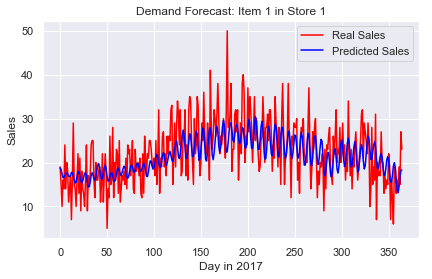

In [29]:
plot_predictions(test_set,predicted_sales)

In [42]:
return_rmse(test_set,predicted_sales)

The root mean squared error is 5.443730361097766.


In [31]:
print("The average actual daily sales is {}.".format(np.mean(test_set)))

The average actual daily sales is 22.183561643835617.


In [32]:
print("The average predicted daily sales is {}.".format(np.mean(predicted_sales)))

The average predicted daily sales is 21.455930709838867.


In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [35]:
mape = mean_absolute_percentage_error(test_set, predicted_sales)
print("The mean absolute percentage error is {}.".format(mape))

The mean absolute percentage error is 0.22364753912562907.


In [50]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_sales))
z_score = 1.65
safety_stock = rmse*z_score
date = 250
def supplies_needed(date, predicted_sales, safety_stock):
    return predicted_sales[date] + safety_stock
print("Stock needed for item 1 in store 1:")
print(supplies_needed(date, predicted_sales, safety_stock))
print("Day of the year:")
print(date)

Stock needed for item 1 in store 1:
[35.25263]
Day of the year:
250
